In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import imageio
import scipy.io as spio
import cv2
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys
from scipy.spatial import Delaunay
import matplotlib.image as mpimg
import dlib

%matplotlib inline
plt.style.use('default')

Step 0: Read images

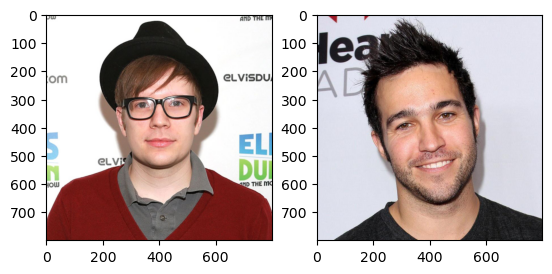

In [3]:
# the follow images are members of my favourite band Fall Out Boy
image1 = plt.imread("Orifaces\\patrick.jpg")
image2 = plt.imread("Orifaces\\pete.jpg")
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)

step = 10

Step 1: Find some corresponding face landmarks between start and end images and display them

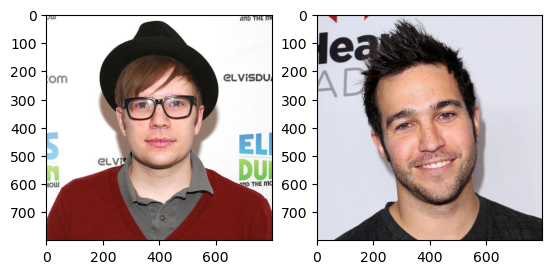

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_landmarks(image):
    img_show = image.copy()
    landmarks = []
    detections = detector(image, 1)
    for k, d in enumerate(detections):
        shape = predictor(image, d)
        for i in range(0, 68):
            x = shape.part(i).x
            y = shape.part(i).y
            landmarks.append((x, y))
            # draw landmarks point on image
            cv2.circle(img_show, (x, y), 1, (0, 0, 255), -1)
    return landmarks, img_show

landmarks1, image1_with_landmarks = get_landmarks(image1)
landmarks2, image2_with_landmarks = get_landmarks(image2)

plt.subplot(1, 2, 1)
plt.imshow(image1_with_landmarks)
plt.subplot(1, 2, 2)
plt.imshow(image2_with_landmarks)

Step 2:  Create a triangulation and visualise it.

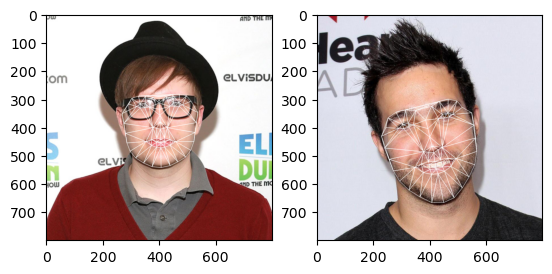

In [5]:
def draw_delaunay(img, points, triangles, color=(255, 255, 255)):
    # draw the triangles using given triangle indices
    img_show = img.copy()
    for tri in triangles:
        pt1 = (int(points[tri[0]][0]), int(points[tri[0]][1]))
        pt2 = (int(points[tri[1]][0]), int(points[tri[1]][1]))
        pt3 = (int(points[tri[2]][0]), int(points[tri[2]][1]))

        cv2.line(img_show, pt1, pt2, color, 1, cv2.LINE_AA, 0)
        cv2.line(img_show, pt2, pt3, color, 1, cv2.LINE_AA, 0)
        cv2.line(img_show, pt3, pt1, color, 1, cv2.LINE_AA, 0)
    return img_show

# Create Delaunay triangulation for the first image
delaunay_triangles1 = Delaunay(landmarks1)

# visualize
image1_show = draw_delaunay(image1, landmarks1, delaunay_triangles1.simplices)
image2_show = draw_delaunay(image2, landmarks2, delaunay_triangles1.simplices)

plt.subplot(1, 2, 1)
plt.imshow(image1_show)
plt.subplot(1, 2, 2)
plt.imshow(image2_show)
plt.show()

# get the triangles indexes
delaunay_triangles1 = delaunay_triangles1.simplices
# print(delaunay_triangles1) # indexes

Step3: Create the intermediate image coordinates

In [6]:
def interpolate_points(p1, p2, steps = step):
    # Create an array to hold the interpolated points
    interpolated_points = np.zeros((steps, p1.shape[0], 3, 2), dtype=np.float32)
    
    for t in range(p1.shape[0]):
        for v in range(3):  # Three vertices per triangle
            # Linear interpolation for x coordinate
            interpolated_points[:, t, v, 0] = np.linspace(p1[t, v, 0], p2[t, v, 0], num=steps)
            # Linear interpolation for y coordinate
            interpolated_points[:, t, v, 1] = np.linspace(p1[t, v, 1], p2[t, v, 1], num=steps)
            
    return interpolated_points

# Get the actual triangle vertices for each image
triangles1 = np.array([[landmarks1[vertex] for vertex in triangle] for triangle in delaunay_triangles1])
triangles2 = np.array([[landmarks2[vertex] for vertex in triangle] for triangle in delaunay_triangles1])

# Perform interpolation
interpolated_triangles = interpolate_points(triangles1, triangles2)
print(interpolated_triangles)

[[[[320.      327.     ]
   [275.      387.     ]
   [269.      352.     ]]

  [[483.      321.     ]
   [513.      308.     ]
   [537.      348.     ]]

  [[513.      308.     ]
   [483.      321.     ]
   [497.      289.     ]]

  ...

  [[420.      450.     ]
   [419.      438.     ]
   [439.      444.     ]]

  [[406.      452.     ]
   [420.      450.     ]
   [420.      453.     ]]

  [[420.      450.     ]
   [406.      452.     ]
   [406.      443.     ]]]


 [[[316.55554 335.55554]
   [271.      396.66666]
   [264.44446 360.8889 ]]

  [[482.66666 324.77777]
   [513.1111  310.44446]
   [538.1111  348.1111 ]]

  [[513.1111  310.44446]
   [482.66666 324.77777]
   [496.77777 291.     ]]

  ...

  [[422.22223 458.22223]
   [421.      446.55554]
   [441.77777 451.33334]]

  [[407.44446 460.66666]
   [422.22223 458.22223]
   [422.66666 462.77777]]

  [[422.22223 458.22223]
   [407.44446 460.66666]
   [407.1111  451.77777]]]


 [[[313.1111  344.1111 ]
   [267.      406.33334]
   [259.

Step4: For every pair of corresponding triangles, take the 3 pairs of corresponding vertices and estimate an Affine warp.

In [7]:
def estimate_affine_transform(src_triangle, dst_triangle):
    # Create a matrix with columns for x, y, and 1 for the source points
    A = np.matrix([
        [src_triangle[0][0], src_triangle[0][1], 1],
        [src_triangle[1][0], src_triangle[1][1], 1],
        [src_triangle[2][0], src_triangle[2][1], 1]
    ])
    
    # Create a matrix for the destination points
    B = np.matrix([
        [dst_triangle[0][0], dst_triangle[0][1]],
        [dst_triangle[1][0], dst_triangle[1][1]],
        [dst_triangle[2][0], dst_triangle[2][1]]
    ])
    
    # Solve for the affine transformation matrix
    affine_transform = np.linalg.inv(A.T * A) * A.T * B
    # if np.allclose(A @ affine_transform, B):
    #     print("qwe")
    # else:
    #     print("ert")
    return affine_transform

num_of_interpolations, num_of_triangles, _, _ = interpolated_triangles.shape
print(interpolated_triangles.shape)
affine_transforms = np.zeros((num_of_interpolations, num_of_triangles, 3, 2))
for i in range(num_of_interpolations - 1):
    for j in range(num_of_triangles):
        affine_transform = estimate_affine_transform(interpolated_triangles[i, j], interpolated_triangles[i + 1, j])
        affine_transforms[i, j] = affine_transform


(10, 116, 3, 2)


Step5: Map all corresponding points between the triangles.

In [8]:
def is_point_in_triangle(pt, tri):
    """检查点是否在三角形内"""
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    b1 = sign(pt, tri[0], tri[1]) < 0.0
    b2 = sign(pt, tri[1], tri[2]) < 0.0
    b3 = sign(pt, tri[2], tri[0]) < 0.0

    return ((b1 == b2) and (b2 == b3))

def map_points(src_triangle, dst_triangle, affine_transform):
    # 计算源三角形的边界矩形
    min_x = min([v[0] for v in src_triangle])
    max_x = max([v[0] for v in src_triangle])
    min_y = min([v[1] for v in src_triangle])
    max_y = max([v[1] for v in src_triangle])

    # 遍历源三角形的每个点
    points_mapping = []
    for y in range(min_y, max_y + 1):
        for x in range(min_x, max_x + 1):
            #if is_point_in_triangle((x, y), src_triangle):
            if cv2.pointPolygonTest(src_triangle, (x, y), False) >= 0:
                # 计算映射后的点
                src_pt = np.array([x, y, 1])
                dst_pt = src_pt @ affine_transform
                #print(dst_pt)
                # dst_pt = dst_pt / dst_pt[2]  # 将齐次坐标转换回二维坐标
                points_mapping.append(((x, y), (dst_pt[0, 0], dst_pt[0, 1])))

    return points_mapping

# # 示例使用
# for i in range(num_of_interpolations - 1):
#     for j in range(num_of_triangles):
#         # 算出每个三角形中的每个点接下来该去哪儿
#         points_mapping = map_points(interpolated_triangles[i, j], interpolated_triangles[i + 1, j], affine_transforms[i, j])



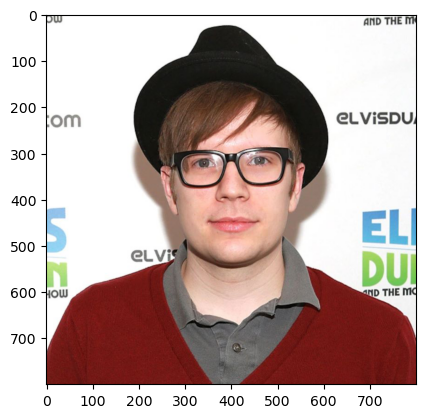

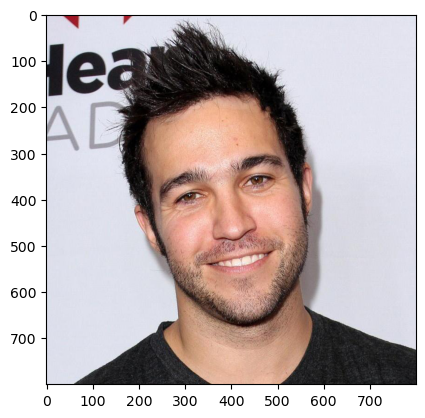

(10, 116, 3, 2)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


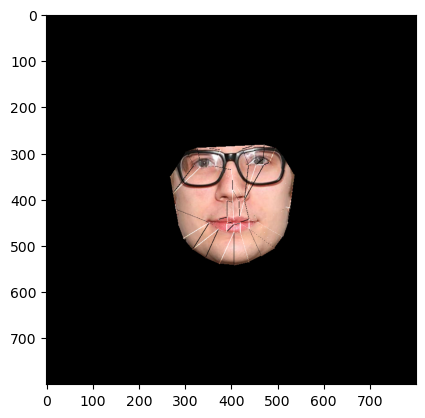

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


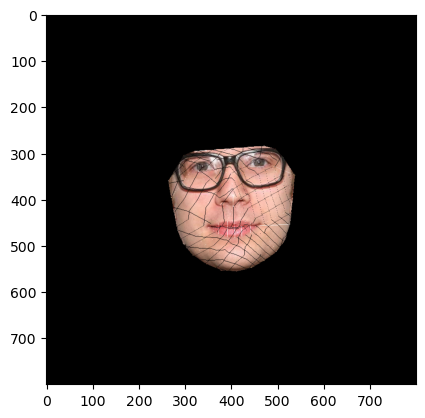

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


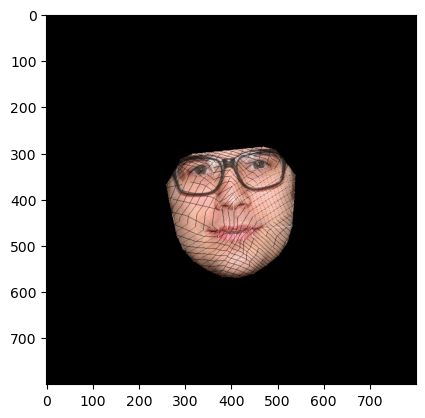

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


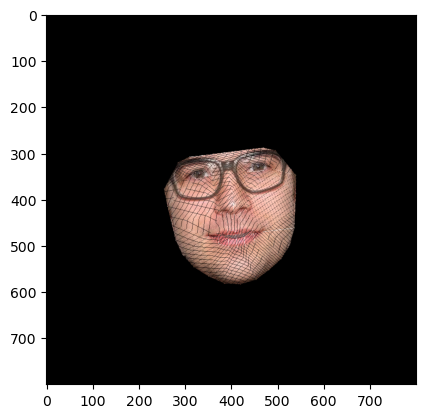

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


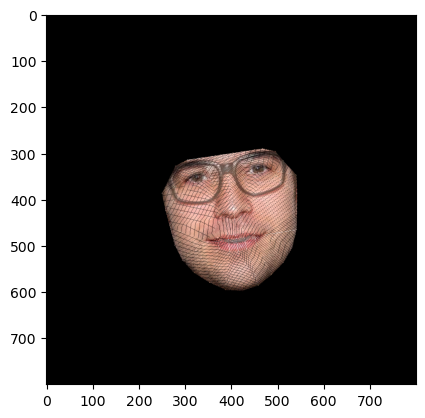

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


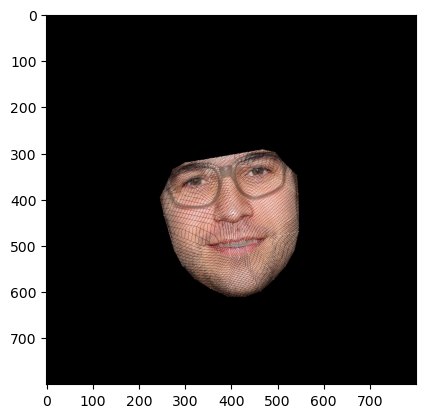

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


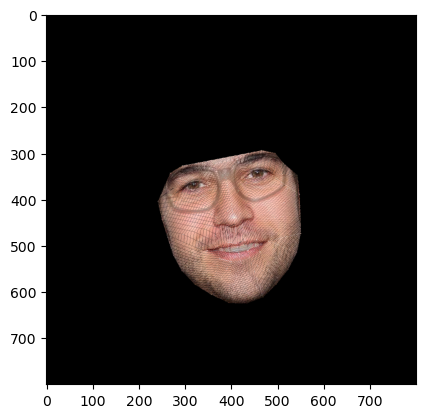

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


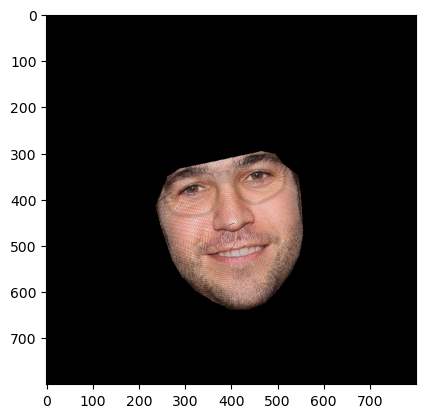

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


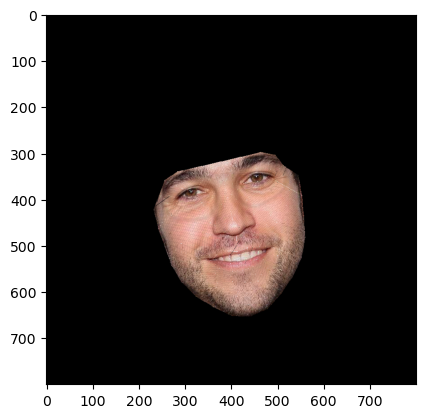

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


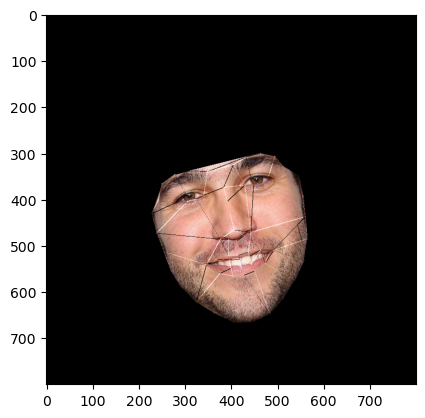

In [11]:
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

def warp_triangle(image, src_triangle, dst_triangle):
    # 创建一个空的变形图像
    warped_image = np.zeros_like(image)
    # 获取源和目标三角形的仿射变换矩阵
    affine_transform = estimate_affine_transform(src_triangle, dst_triangle)
    # 映射源三角形到目标三角形的点
    points_mapping = map_points(src_triangle, dst_triangle, affine_transform)
    # 对每个点应用映射
    for src, dst in points_mapping:
        x, y = int(src[0]), int(src[1])
        x_dst, y_dst = int(dst[0]), int(dst[1])
        if 0 <= x_dst < image.shape[1] and 0 <= y_dst < image.shape[0]:
            warped_image[y_dst, x_dst] = bilinear_interpolate(image, y, x)
    return warped_image

#双线性插值
def bilinear_interpolate(img, y, x):
    #（x0,y0)是左上角像素点
    x0 = int(x)
    y0 = int(y)
    #（x1,y1）是右下角像素点
    x1 = x0 + 1
    y1 = y0 + 1
    #左上像素值Ia，左下像素值Ib，右上Ic
    Ia = img[y0, x0]
    Ib = img[y1, x0]
    Ic = img[y0, x1]
    Id = img[y1, x1]
    #权重是根据目标点与邻近四个像素坐标的相对距离来计算的。
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)
    #使用加权平均的方法计算插值
    return wa * Ia + wb * Ib + wc * Ic + wd * Id

def blend_images(image1, image2, weight):
    # 线性混合两个图像
    return (1 - weight) * image1 + weight * image2

height, width, c = image1.shape
stepCur = 0

print(interpolated_triangles.shape)

# 假设 step 已经定义为需要的步数
num_steps = 10

# 对每个权重值进行操作
for w in np.linspace(0, 1, num=num_steps):
    # 当前步骤的索引
    stepCur = int(round(w * (num_steps - 1)))
    
    # 变形 S_image 和 E_image
    warped_S = np.zeros_like(image1, dtype=np.float32)
    warped_E = np.zeros_like(image2, dtype=np.float32)
    
    # 获取当前步骤的插值三角形
    interpolated_tri = interpolated_triangles[stepCur]

    # 对每个三角形进行变形和融合
    for i, (src_tri, dst_tri) in enumerate(zip(triangles1, triangles2)):
        # 变形 S_image 和 E_image
        warped_S += warp_triangle(image1, src_tri, interpolated_tri[i])
        warped_E += warp_triangle(image2, dst_tri, interpolated_tri[i])
    
    warped_S = np.clip(warped_S, 0, 255)
    warped_E = np.clip(warped_E, 0, 255)
    # process the pixels not included in the triangles
    # print(warped_S)
    # mask = (warped_S == 0)
    # warped_S[mask] = image1[mask]
    # mask = (warped_E == 0)
    # warped_E[mask] = image2[mask]
    
    # 混合变形后的图像
    blended_image = blend_images(warped_S, warped_E, w)
    print(blended_image)
    # 确保像素值在0到255之间
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

    plt.imshow(blended_image)
    plt.show()
    # 可以在这里使用 cv2.imwrite 来保存每一步的融合图像

